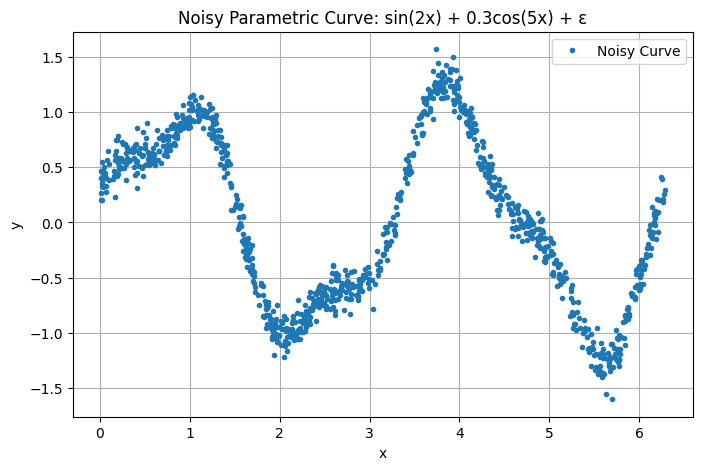

In [8]:
import torch
import matplotlib.pyplot as plt
import math

torch.manual_seed(42)
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)
epsilon = 0.1 * torch.randn(train_data_length)
train_data[:, 1] = torch.sin(2 * train_data[:, 0]) + 0.3 * torch.cos(5 * train_data[:, 0]) + epsilon

plt.figure(figsize=(8, 5))
plt.plot(train_data[:, 0], train_data[:, 1], '.', label='Noisy Curve')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Noisy Parametric Curve: sin(2x) + 0.3cos(5x) + ε")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# --- Data: Noisy Parametric Curve ---
torch.manual_seed(42)
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)
epsilon = 0.1 * torch.randn(train_data_length)
train_data[:, 1] = torch.sin(2 * train_data[:, 0]) + 0.3 * torch.cos(5 * train_data[:, 0]) + epsilon

train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)


In [10]:

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# --- Generator ---
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# --- Instantiate Models ---
discriminator = Discriminator()
generator = Generator()


In [11]:

# --- Training Setup ---
num_epochs = 15000
learning_rate = 0.0003
batch_size = 64
loss_function = nn.BCELoss()
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate)


In [12]:

# --- Training Loop ---
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # === Train Discriminator ===
        real_samples_labels = torch.ones((batch_size, 1)) * (0.8 + 0.2 * torch.rand((batch_size, 1)))
        latent_space_samples = torch.randn((batch_size, 2)) * 2 * math.pi
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        all_samples = torch.cat((real_samples, generated_samples))
        all_labels = torch.cat((real_samples_labels, generated_samples_labels))

        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train Generator ===
        latent_space_samples = torch.randn((batch_size, 2)) * 2 * math.pi
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # --- Print loss every 500 epochs ---
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_discriminator.item():.4f} | G Loss: {loss_generator.item():.4f}")


Epoch 0 | D Loss: 0.6081 | G Loss: 0.6882
Epoch 500 | D Loss: 0.6947 | G Loss: 0.8632
Epoch 1000 | D Loss: 0.6783 | G Loss: 0.8485
Epoch 1500 | D Loss: 0.6875 | G Loss: 0.7717
Epoch 2000 | D Loss: 0.6799 | G Loss: 0.8061
Epoch 2500 | D Loss: 0.6925 | G Loss: 0.8191
Epoch 3000 | D Loss: 0.6754 | G Loss: 0.8010
Epoch 3500 | D Loss: 0.6748 | G Loss: 0.7969
Epoch 4000 | D Loss: 0.6671 | G Loss: 0.8071
Epoch 4500 | D Loss: 0.6630 | G Loss: 0.8129
Epoch 5000 | D Loss: 0.6692 | G Loss: 0.7995
Epoch 5500 | D Loss: 0.6845 | G Loss: 0.8066
Epoch 6000 | D Loss: 0.6822 | G Loss: 0.8353
Epoch 6500 | D Loss: 0.6703 | G Loss: 0.7924
Epoch 7000 | D Loss: 0.6951 | G Loss: 0.8060
Epoch 7500 | D Loss: 0.6680 | G Loss: 0.8613
Epoch 8000 | D Loss: 0.6902 | G Loss: 0.7901
Epoch 8500 | D Loss: 0.6841 | G Loss: 0.8314
Epoch 9000 | D Loss: 0.6903 | G Loss: 0.7751
Epoch 9500 | D Loss: 0.7056 | G Loss: 0.8024
Epoch 10000 | D Loss: 0.6330 | G Loss: 0.8379
Epoch 10500 | D Loss: 0.7090 | G Loss: 0.7848
Epoch 11000 

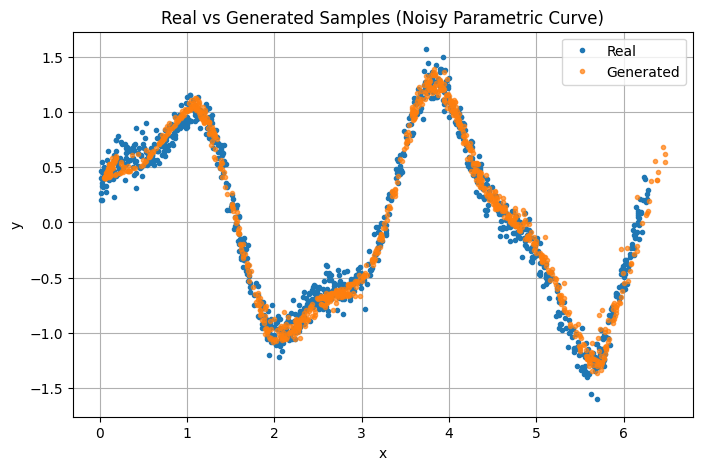

In [13]:
import numpy as np

# --- Plot Real vs Generated Data ---
with torch.no_grad():
    latent = torch.randn(1000, 2) * 2 * math.pi  # same latent input scale
    generated = generator(latent).detach().numpy()

plt.figure(figsize=(8, 5))
plt.plot(train_data[:, 0], train_data[:, 1], '.', label='Real')
plt.plot(generated[:, 0], generated[:, 1], '.', alpha=0.7, label='Generated')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Real vs Generated Samples (Noisy Parametric Curve)")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [117]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from medmnist import INFO, PathMNIST
import numpy as np

# Set up transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # normalize 3-channel RGB
])

# Load dataset
info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist', fromlist=[info['python_class']]), info['python_class'])
train_dataset = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Explore dataset
label_info = info['label']  # Dictionary of class index → class name
num_classes = len(label_info)
print(f"Number of classes: {num_classes}")
print("Class labels:")
for k, v in label_info.items():
    print(f"{k}: {v}")


Number of classes: 9
Class labels:
0: adipose
1: background
2: debris
3: lymphocytes
4: mucus
5: smooth muscle
6: normal colon mucosa
7: cancer-associated stroma
8: colorectal adenocarcinoma epithelium


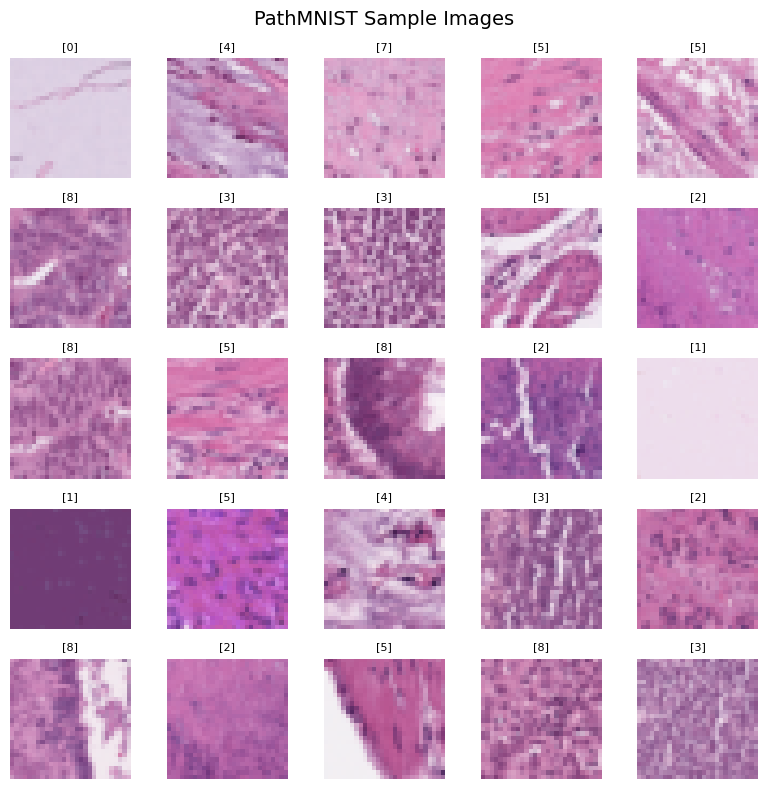

In [120]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import INFO, PathMNIST
from torch.utils.data import DataLoader

# Load dataset
info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist', fromlist=[info['python_class']]), info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = DataClass(split='train', transform=transform, download=True)

# Label mapping
class_names = info['label']  # e.g., {'0': 'adipose tissue', ..., '8': 'squamous epithelial'}

# Show sample images with class names
def show_sample_images(dataset, n=25):
    rows, cols = 5, 5
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))  # slightly larger
    for i in range(n):
        img, label = dataset[i]
        img = img * 0.5 + 0.5  # Unnormalize
        img_np = img.permute(1, 2, 0).numpy()

        ax = axes[i // cols, i % cols]
        ax.imshow(img_np)
        
        # Convert label to string for lookup
        label_str = str(label.item()) if isinstance(label, torch.Tensor) else str(label)
        label_name = class_names.get(label_str, label_str)
        
        ax.set_title(label_name, fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.suptitle("PathMNIST Sample Images", fontsize=14)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Call the function
show_sample_images(train_dataset)

In [15]:
from medmnist import INFO, PathMNIST
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Dataset info
info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist', fromlist=[info['python_class']]), info['python_class'])

# Download training set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_ds = DataClass(split='train', transform=transform, download=True)
val_ds = DataClass(split='val', transform=transform, download=True)
test_ds = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


In [ ]:
from torchvision import transforms
from torchvision.utils import make_grid
from medmnist import INFO, PathMNIST
import matplotlib.pyplot as plt

# ---- Config ----
device = torch.device("cpu")  # Change to 'cuda' if using GPU
latent_dim = 100
batch_size = 64
n_epochs = 100
n_critic = 5
clip_value = 0.01
lr = 0.00005


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from medmnist import INFO
import matplotlib.pyplot as plt

# Dataset
from medmnist import PathMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Use 3 channels for RGB
])
info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist', fromlist=[info['python_class']]), info['python_class'])
train_ds = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


Epoch 0 | Loss D: 0.9413 | Loss G: 0.8541
Epoch 5 | Loss D: 1.5965 | Loss G: 4.6429
Epoch 10 | Loss D: 0.8549 | Loss G: 3.8794
Epoch 15 | Loss D: 0.8349 | Loss G: 2.1814
Epoch 20 | Loss D: 0.6423 | Loss G: 1.3962
Epoch 25 | Loss D: 1.1895 | Loss G: 2.7594
Epoch 30 | Loss D: 0.5280 | Loss G: 1.7131
Epoch 35 | Loss D: 0.8353 | Loss G: 2.5882
Epoch 40 | Loss D: 0.5036 | Loss G: 3.5921
Epoch 45 | Loss D: 0.2237 | Loss G: 3.2157
Epoch 50 | Loss D: 0.9371 | Loss G: 2.2324
Epoch 55 | Loss D: 1.1373 | Loss G: 3.6019
Epoch 60 | Loss D: 2.0078 | Loss G: 2.8168
Epoch 65 | Loss D: 1.6078 | Loss G: 3.1613
Epoch 70 | Loss D: 0.7175 | Loss G: 2.4137
Epoch 75 | Loss D: 1.5308 | Loss G: 2.6386
Epoch 80 | Loss D: 1.6152 | Loss G: 1.3360
Epoch 85 | Loss D: 1.0473 | Loss G: 2.6062
Epoch 90 | Loss D: 1.0168 | Loss G: 2.0539
Epoch 95 | Loss D: 0.7615 | Loss G: 2.5875


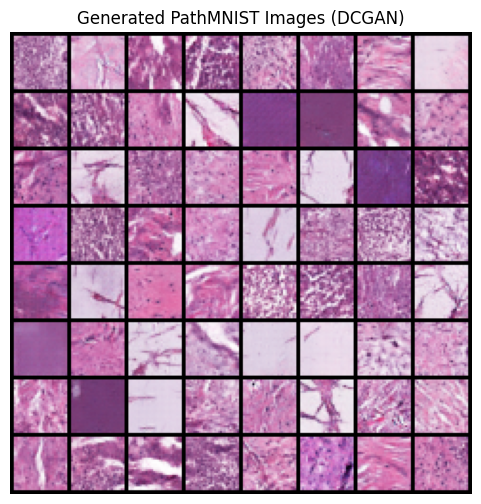

In [48]:


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
netG = DCGANGenerator(latent_dim).to(device)
netD = DCGANDiscriminator().to(device)

# Optimizers and Loss
criterion = nn.BCELoss()
opt_d = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
num_epochs = 100
for epoch in range(num_epochs):
    for imgs, _ in train_loader:
        real = imgs.to(device)
        bs = real.size(0)
        labels_real = torch.ones(bs, 1, device=device)
        labels_fake = torch.zeros(bs, 1, device=device)

        # Discriminator
        noise = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        d_real = netD(real)
        d_fake = netD(fake.detach())
        loss_d = criterion(d_real, labels_real) + criterion(d_fake, labels_fake)
        opt_d.zero_grad(); loss_d.backward(); opt_d.step()

        # Generator
        d_fake_for_g = netD(fake)
        loss_g = criterion(d_fake_for_g, labels_real)
        opt_g.zero_grad(); loss_g.backward(); opt_g.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f}")

# Visualize
with torch.no_grad():
    samples = netG(torch.randn(64, latent_dim, 1, 1).to(device)).cpu()

grid = utils.make_grid((samples * 0.5 + 0.5), nrow=8)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated PathMNIST Images (DCGAN)")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_real_vs_generated(generator, data_loader, latent_dim, device, n_images=8):
    # Fetch a batch of real images
    real_imgs, _ = next(iter(data_loader))
    real_imgs = real_imgs[:n_images].to(device)

    # Generate fake images
    noise = torch.randn(n_images, latent_dim, 1, 1, device=device)
    fake_imgs = generator(noise).detach().cpu()

    # Denormalize
    real_imgs = real_imgs.cpu() * 0.5 + 0.5
    fake_imgs = fake_imgs * 0.5 + 0.5

    # Plot
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 2, 4))

    for i in range(n_images):
        axes[0, i].imshow(real_imgs[i].permute(1, 2, 0))
        axes[0, i].set_title("Real", fontsize=8)
        axes[0, i].axis("off")

        axes[1, i].imshow(fake_imgs[i].permute(1, 2, 0))
        axes[1, i].set_title("Fake", fontsize=8)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.suptitle("Real vs Generated Images", fontsize=14, y=1.05)
    plt.show()

Real images shape: torch.Size([8, 3, 28, 28])
Fake images shape: torch.Size([8, 3, 28, 28])
Real image range: 0.15294116735458374 to 0.9843137264251709
Fake image range: 0.13090065121650696 to 0.9754047989845276


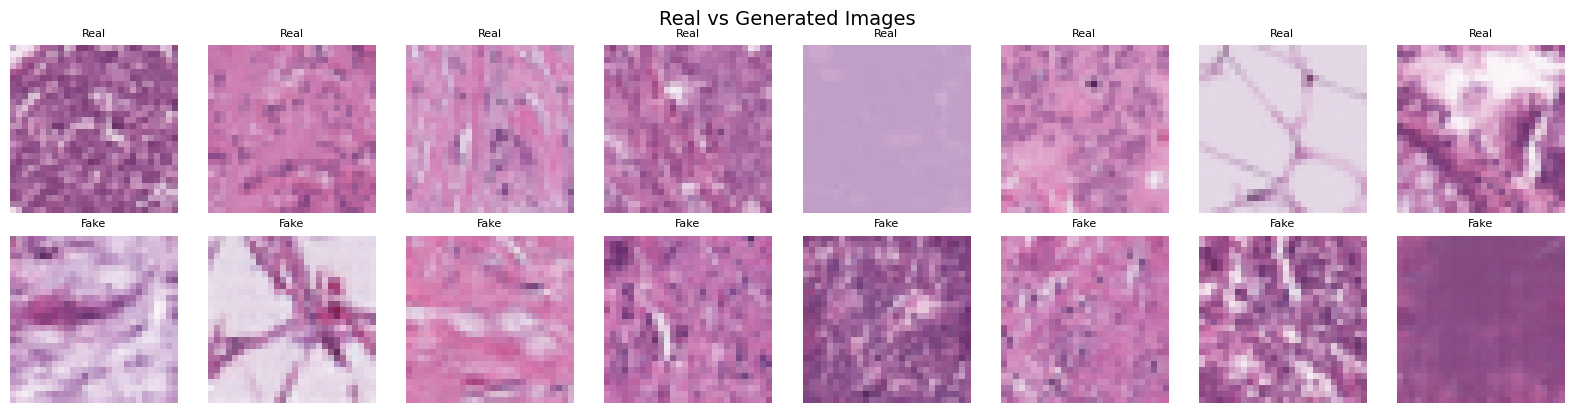

In [82]:
show_real_vs_generated(generator=netG, data_loader=train_loader, latent_dim=100, device=device)

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from medmnist import INFO, PathMNIST
import numpy as np

# --------------------- Configuration ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
num_classes = 9
img_size = 28
channels = 3
img_shape = (channels, img_size, img_size)
batch_size = 64
num_epochs = 50
lr = 0.0002
betas = (0.5, 0.999)

# --------------------- Data ---------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist', fromlist=[info['python_class']]), info['python_class'])
train_ds = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# --------------------- Generator ---------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),  # Output: 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # Output: 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # Output: 3x28x28
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = noise * self.label_emb(labels)
        x = x.view(x.size(0), latent_dim, 1, 1)
        return self.model(x)

# --------------------- Discriminator ---------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, channels * img_size * img_size)
        self.model = nn.Sequential(
            nn.Conv2d(channels * 2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7, 1, 0),  # 7x7 → 1x1
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_img = self.label_emb(labels).view(labels.size(0), channels, img_size, img_size)
        d_in = torch.cat((img, label_img), dim=1)
        return self.model(d_in)

# --------------------- Initialize ---------------------
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# --------------------- Training ---------------------
for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long().to(device)
        bs = imgs.size(0)

        valid = torch.ones(bs, 1, 1, 1).to(device)
        fake = torch.zeros(bs, 1, 1, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(bs, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (bs,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")



[Epoch 1/50] D_loss: 0.1252 | G_loss: 2.3709
[Epoch 2/50] D_loss: 1.7666 | G_loss: 1.0023
[Epoch 3/50] D_loss: 1.0121 | G_loss: 1.6687
[Epoch 4/50] D_loss: 0.1586 | G_loss: 4.8831
[Epoch 5/50] D_loss: 0.7211 | G_loss: 0.7275
[Epoch 6/50] D_loss: 0.3454 | G_loss: 2.5438
[Epoch 7/50] D_loss: 0.0884 | G_loss: 1.9002
[Epoch 8/50] D_loss: 0.3322 | G_loss: 4.7613
[Epoch 9/50] D_loss: 0.8898 | G_loss: 0.1930
[Epoch 10/50] D_loss: 0.0691 | G_loss: 2.0685
[Epoch 11/50] D_loss: 0.2996 | G_loss: 2.3248
[Epoch 12/50] D_loss: 0.7756 | G_loss: 0.2975
[Epoch 13/50] D_loss: 1.7233 | G_loss: 0.0475
[Epoch 14/50] D_loss: 1.5099 | G_loss: 0.1709
[Epoch 15/50] D_loss: 2.4549 | G_loss: 5.6593
[Epoch 16/50] D_loss: 1.0402 | G_loss: 0.1603
[Epoch 17/50] D_loss: 0.1034 | G_loss: 1.8360
[Epoch 18/50] D_loss: 1.4695 | G_loss: 0.2544
[Epoch 19/50] D_loss: 0.4639 | G_loss: 0.5271
[Epoch 20/50] D_loss: 0.9277 | G_loss: 0.2057
[Epoch 21/50] D_loss: 0.3416 | G_loss: 0.7491
[Epoch 22/50] D_loss: 1.2085 | G_loss: 2.27

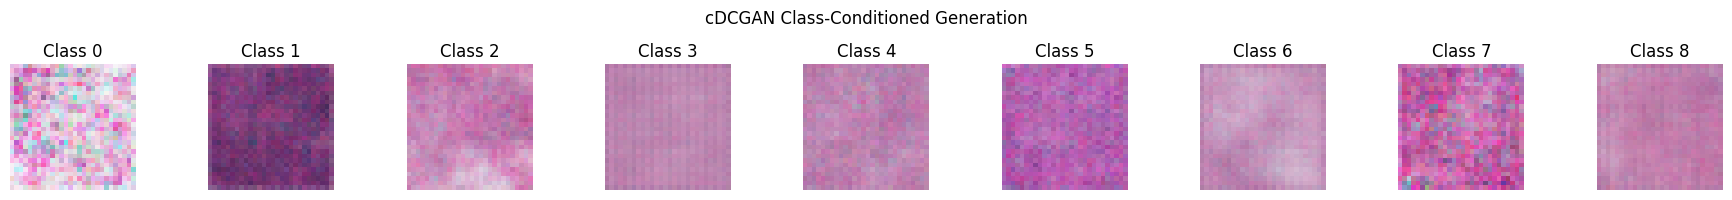

In [71]:
# --------------------- Generate Class-Specific Samples ---------------------
generator.eval()
with torch.no_grad():
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))
    for i in range(num_classes):
        z = torch.randn(1, latent_dim).to(device)
        label = torch.tensor([i]).to(device)
        img = generator(z, label)
        img = img * 0.5 + 0.5  # unnormalize
        axes[i].imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"Class {i}")
        axes[i].axis("off")
    plt.suptitle("cDCGAN Class-Conditioned Generation")
    plt.tight_layout()
    plt.show()